In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [3]:
faults_BFSZ_file = os.path.join("data", "Mei_2009_faults_BFSZ.shp")
faults_montney_file = os.path.join("data", "Mei_2009_faults_Montney.shp")
faults_debolt_file = os.path.join("data", "Mei_2009_faults_Debolt.shp")

In [4]:
faults_BFSZ = gpd.read_file(faults_BFSZ_file)
faults_montney = gpd.read_file(faults_montney_file)
faults_debolt = gpd.read_file(faults_debolt_file)

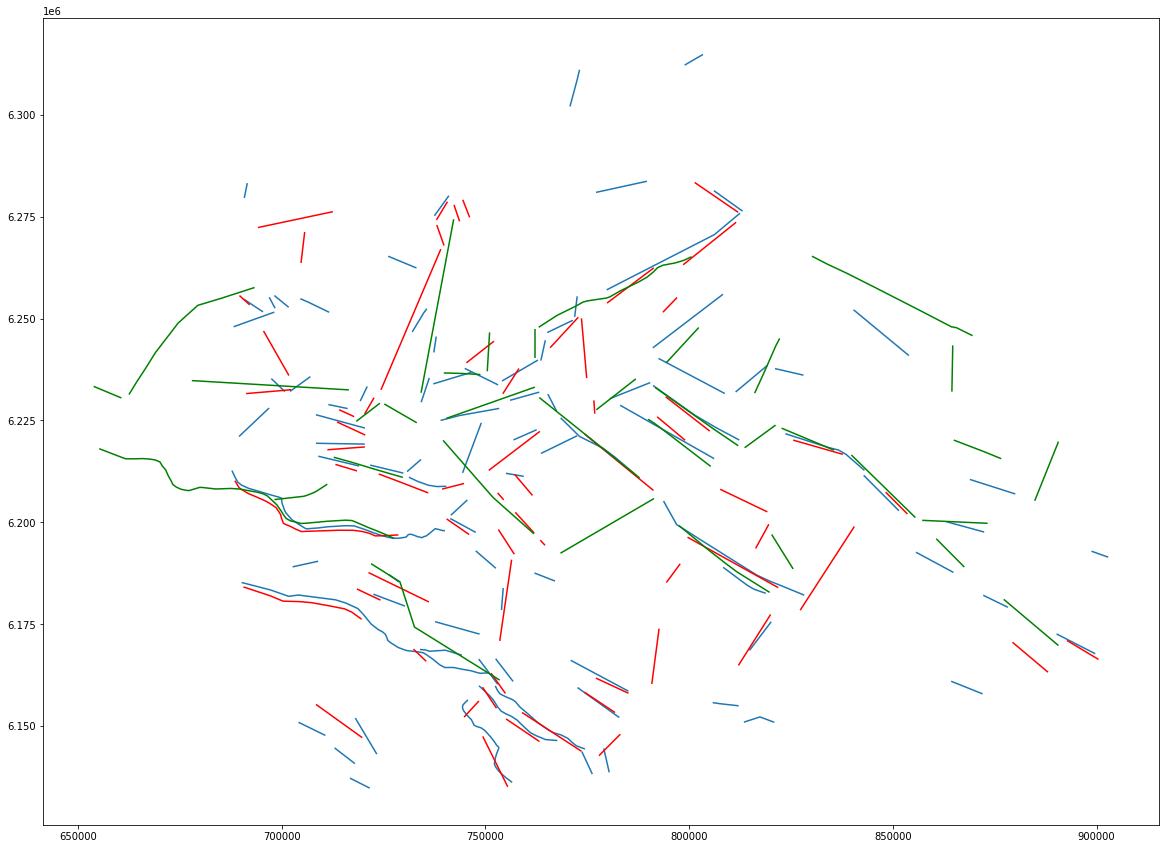

In [5]:
fig, ax = plt.subplots(figsize=(20, 20))
faults_BFSZ.plot(ax=ax)
faults_montney.plot(ax=ax, color='r')
faults_debolt.plot(ax=ax, color='g');

Reference datum for NAD83 coordinates = GRS80

In [6]:
from geographiclib.geodesic import Geodesic

def coords(geom):
    return list(geom.coords)

def calculate_azimuth(lat1, lon1, lat2, lon2):
    azi = Geodesic.WGS84.Inverse(lat1, lon1, lat2, lon2)['azi1']
    return azi
    
def create_coords_azi(df):
    df['lat1'] = df.apply(lambda row: coords(row.geometry)[0][1], axis=1)
    df['lon1'] = df.apply(lambda row: coords(row.geometry)[0][0], axis=1)
    df['lat2'] = df.apply(lambda row: coords(row.geometry)[-1][1], axis=1)
    df['lon2'] = df.apply(lambda row: coords(row.geometry)[-1][0], axis=1)
    df['azi'] = df.apply(lambda row: calculate_azimuth(row.lat1, row.lon1, row.lat2, row.lon2), axis=1)
    return df         

In [7]:
faults_BFSZ['geometry'] = faults_BFSZ['geometry'].to_crs(4326)

faults_BFSZ_azi = create_coords_azi(faults_BFSZ)

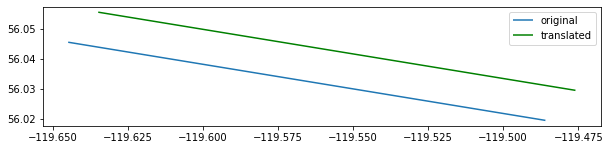

In [8]:
# example of GaoPandas.GeoSeries.translate
orig = gpd.GeoSeries(faults_BFSZ_azi.geometry[0])
trans = gpd.GeoSeries(faults_BFSZ_azi.geometry[0]).translate(0.01,0.01)

fig, ax = plt.subplots(figsize=(10,10))
orig.plot(ax=ax,label='original')
trans.plot(ax=ax,color='g', label='translated')
ax.legend();

1. assign (manually) which point correspond to each fault
2. get lon and lat difference between the 1) intersection of line perpendicular to strike of mapped fault and 2) interpreted location (point on lithoprobe profile)
3. translate shapefile by that difference

Ideas: **1)** add column *orientation* (SE-NW, N-S) **2)**
put in one big project together with visualization of lithoprobe lines etc

In [9]:
from shapely.geometry import LineString, Point
import geopandas as gpd
AB = LineString([(56.045470, -119.644780), (56.019451, -119.485934)])
point = Point(52, -120)
point.distance(AB) # distance in degrees!

4.052190789407252

https://gis.stackexchange.com/questions/21256/shifting-all-features-in-vector-dataset-using-bash-ogr

In [12]:
from fiona import collection
import logging

log = logging.getLogger()

# A few functions to shift coords. They call eachother semi-recursively.
def shiftCoords_Point(coords, delta):
    # delta is a (delta_x, delta_y [, delta_y]) tuple
    return tuple(c + d for c, d in zip(coords, delta))

def shiftCoords_LineString(coords, delta):
    return list(shiftCoords_Point(pt_coords, delta) for pt_coords in coords)

def shiftCoords_Polygon(coords, delta):
    return list(
        shiftCoords_LineString(ring_coords, delta) for ring_coords in coords)

# We'll use a map of these functions in the processing code below.
shifters = {
    'Point': shiftCoords_Point,
    'LineString': shiftCoords_LineString,
    'Polygon': shiftCoords_Polygon }

# Example 2D shift, 1 unit eastward and northward
delta = (10000.0, 10000.0) # shift all shapefiles by the same distance
# with collection("data/Mei_2009_faults_BFSZ.shp", "r") as source:

#     # Create a sink for processed features with the same format and 
#     # coordinate reference system as the source.
#     with collection(
#             "Mei_2009_faults_BFSZ_shifted.shp", 
#             "w",
#             driver=source.driver,
#             schema=source.schema,
#             crs=source.crs
#             ) as sink:

#         for rec in source:
#             try:
#                 g = rec['geometry']
#                 g['coordinates'] = shifters[g['type']](
#                     g['coordinates'], delta )
#                 rec['geometry'] = g
#                 sink.write(rec)
#             except:
#                 log.exception("Error processing record %s:", rec)

work on geopackage

In [13]:
# import fiona

# # with fiona.open('data/test.gpkg') as layers:
# #     print(layers)
# # #     for feature in layers:
# # #         print(feature['geometry'])

# # No need to pass "layer='etc'" if there's only one layer
# with fiona.open('data/test.gpkg', layer='Mei_2009_faults_BFSZ') as layer:
#     print(type(layer))
# #     for feature in layer:
# #         print(type(feature.geometry))
# #         print(feature['geometry'])


# import pprint
# import fiona
# with fiona.open('data/test.gpkg') as src:
#     pprint.pprint(src[2])